# Cyclone tracking based on relative vorticity in kilometer-scale simulations 

This example notebook demonstrates the use of tobac to track meso-scale vortices, based on the relative vorticity field in kilometer-scale simulations. Since such simulations are characterized by high frequencies in the vorticity field (especially in regions with complex terrain), *tobac* allows you to spectrally filter the input data by applying a bandpass filter based on user-specified wavelengths. This results in the removal of submeso-scale noise. For more details about the used filter method and the **discrete cosine transformation** that is used to transfer input data to the spectral space is given in [Denis et al. 2002](https://journals.ametsoc.org/view/journals/mwre/130/7/1520-0493_2002_130_1812_sdotda_2.0.co_2.xml?tab_body=fulltext-display). 

**Data description** 

The data used in this example is relative vorticity from a 4km [WRF](https://ncar.ucar.edu/what-we-offer/models/weather-research-and-forecasting-model-wrf) simulation in the Tibetan Plateau-Himalaya region. This data is part of the CORDEX Flagship Pilot Study CPTP ("Convection-Permitting Third Pole"). The target weather system, which we want to track here are shallow meso-scale vortices at 500 hPa. The WRF simulation that produced the input data used Thompson microphysics, the Yonsei University (YSU) planetary boundary layer scheme, the RRTMG
longwave and shortwave radiation scheme, and the Noah-MP land surface scheme.

Other applications for the spectral filtering tool in *tobac* could be to detect: 
- MJO 
- equatorial waves 
- atmospheric rivers 
- ...

You can access the data from the [zenodo](https://zenodo.org/) link, which is provided in the notebook.

In [1]:
# Import a range of python libraries used in this notebook:
from pathlib import Path
import urllib

import numpy as np
import pandas as pd
import xarray as xr


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

In [3]:
# Disable a few warnings:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, append=True)
warnings.filterwarnings("ignore", category=RuntimeWarning, append=True)
warnings.filterwarnings("ignore", category=FutureWarning, append=True)
warnings.filterwarnings("ignore", category=pd.io.pytables.PerformanceWarning)

In [4]:
# Import tobac itself:
import tobac

print("using tobac version", str(tobac.__version__))

using tobac version 1.6.2


**Download example data:**  

In [5]:
# change this location if you want to save the downloaded data elsewhere
data_out = Path("../data")
if data_out.exists() is False:
    data_out.mkdir()

In [6]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob("Example_input_vorticity_model.nc"))
if len(data_file) == 0:
    file_path = (
        "https://zenodo.org/record/6459542/files/Example_input_vorticity_model.nc"
    )
    print("start downloading data")
    request = urllib.request.urlretrieve(
        file_path, data_out / ("Example_input_vorticity_model.nc")
    )
    data_file = list(data_out.rglob("Example_input_vorticity_model.nc"))

In [7]:
# Load Data from downloaded file:
data_file = Path(data_out / "Example_input_vorticity_model.nc")
ds = xr.open_dataset(data_file)
# get variables
relative_vorticity = ds.rv500
lats = ds.latitude
lons = ds.longitude

# check out what the data looks like
display(ds)

<xarray.Dataset> Size: 549MB
Dimensions:      (time: 168, south_north: 469, west_east: 866)
Coordinates:
  * time         (time) datetime64[ns] 1kB 2008-07-14 ... 2008-07-20T23:00:00
  * south_north  (south_north) int64 4kB 33 34 35 36 37 ... 497 498 499 500 501
  * west_east    (west_east) int64 7kB 741 742 743 744 ... 1603 1604 1605 1606
    latitude     (south_north, west_east) float32 2MB ...
    longitude    (south_north, west_east) float32 2MB ...
Data variables:
    rv500        (time, south_north, west_east) float64 546MB ...
Attributes:
    simulation:  WRF 4km
    forcing:     ECMWF-ERA5
    institute:   National Center for Atmospheric Research, Boulder
    contact:     julia.kukulies@gu.se

In [8]:
# Set up directory to save output and plots:
savedir = Path("Save")
plotdir = Path("Plots")

savedir.mkdir(parents=True, exist_ok=True)
plotdir.mkdir(parents=True, exist_ok=True)

### Check how the spectrally input field would look like

If you want to check how the filter and your filtered data looked like, you can do that by using the method *tobac.utils.general.spectral_filtering()* directly on your input data. This can be helpful in the development process, if you want to try out different ranges of wavelengths and see how this changes your data. In the example, we use use the spectral filtering method to remove wavelengths < 400 km and > 1000 km, because the focus is on meso-scale vortices. 

#### Create your filter 

In [9]:
help(tobac.utils.general.spectral_filtering)

Help on function spectral_filtering in module tobac.utils.general:

spectral_filtering(
    dxy,
    field_in,
    lambda_min,
    lambda_max,
    return_transfer_function=False
)
    This function creates and applies a 2D transfer function that
    can be used as a bandpass filter to remove certain wavelengths
    of an atmospheric input field (e.g. vorticity, IVT, etc).

    Parameters:
    -----------
    dxy : float
        Grid spacing in m.

    field_in: numpy.array
        2D field with input data.

    lambda_min: float
        Minimum wavelength in m.

    lambda_max: float
        Maximum wavelength in m.

    return_transfer_function: boolean, optional
        default: False. If set to True, then the 2D transfer function and
        the corresponding wavelengths are returned.

    Returns:
    --------
    filtered_field: numpy.array
        Spectrally filtered 2D field of data (with same shape as input data).

    transfer_function: tuple
        Two 2D fields, where the f

In [10]:
# define minimum and maximum wavelength
lambda_min, lambda_max = 400e3, 1000e3
dxy = 4e3

# use spectral filtering method on input data to check how the applied filter changes the data
transfer_function, relative_vorticity_meso = tobac.utils.general.spectral_filtering(
    dxy, relative_vorticity, lambda_min, lambda_max, return_transfer_function=True
)

#### Example for unfiltered vs. filtered input data

The example shows typhoon *Kalmaegi* over Taiwan on July 18$^{th}$, 2008 ; as can be seen the corresponding meso-scale vortex becomes only visible in the spectrally filtered field.

<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
/var/folders/bj/m6g82c6n41g83y3_dx02y7ch0000gp/T/ipykernel_86601/395231216.py:39: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_title("b) WRF 4 km, 400 km $<$ $\lambda$ $<$ 1000 km", fontsize=fs, loc="left")


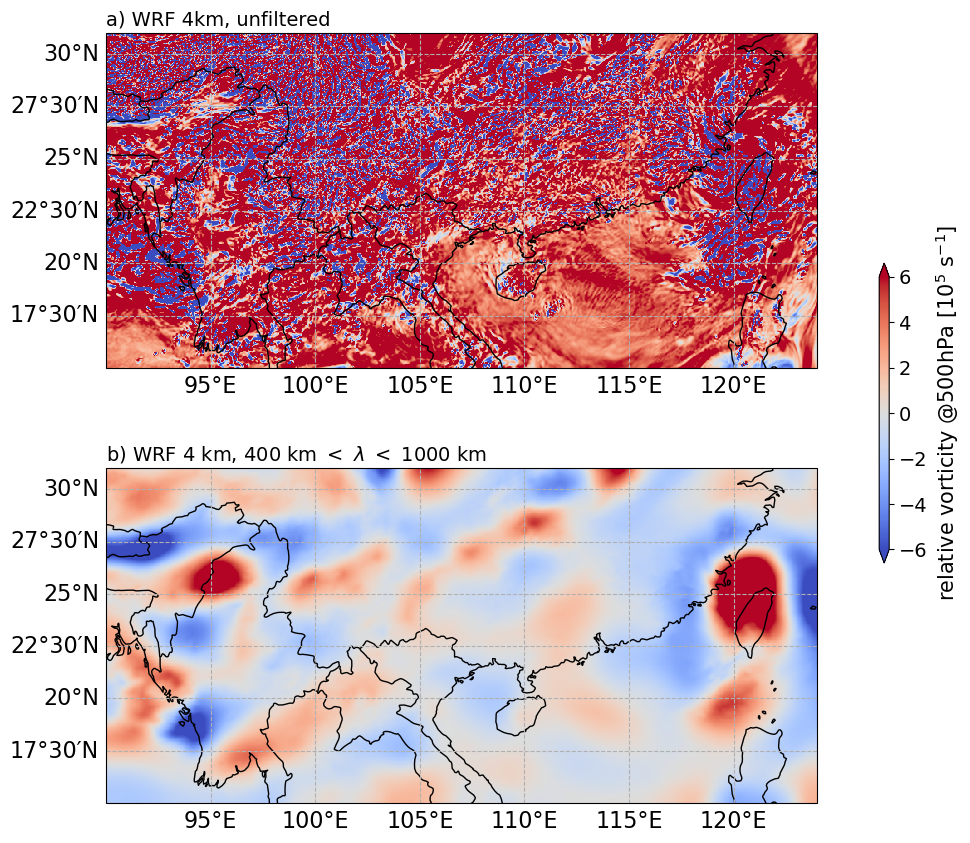

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 10))

fs = 14
axes = dict()
subplots = 2
ax1 = plt.subplot2grid(
    shape=(subplots, 1), loc=(0, 0), rowspan=1, projection=ccrs.PlateCarree()
)
ax2 = plt.subplot2grid(
    shape=(subplots, 1), loc=(1, 0), rowspan=1, projection=ccrs.PlateCarree()
)

plt.subplots_adjust( hspace = 0.3, right = 0.9)
########################################## vortex #############################

cmap = "coolwarm"
# time step to plot
tt = 101
col = "black"
extent = [90, 124, 15, 30]

ax1.set_extent(extent)
ax1.set_title("a) WRF 4km, unfiltered", fontsize=fs, loc="left")
ax1.pcolormesh(lons, lats, relative_vorticity[tt], cmap=cmap, vmin=-6, vmax=6)
ax1.add_feature(cfeature.BORDERS, color="black")
ax1.add_feature(cfeature.COASTLINE, color=col)
gl = ax1.gridlines(
    draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 16, "color": "black"}
gl.ylabel_style = {"size": 16, "color": "black"}

ax2.set_extent(extent)
ax2.set_title("b) WRF 4 km, 400 km $<$ $\lambda$ $<$ 1000 km", fontsize=fs, loc="left")
vort = ax2.pcolormesh(
    lons, lats, relative_vorticity_meso[tt], cmap=cmap, vmin=-6, vmax=6
)
ax2.add_feature(cfeature.COASTLINE, color=col)
ax2.add_feature(cfeature.BORDERS, color="black")
gl = ax2.gridlines(
    draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 16, "color": "black"}
gl.ylabel_style = {"size": 16, "color": "black"}

### colorbar ###
cb_ax2 = fig.add_axes([0.93, 0.35, 0.01, 0.3])
cbar = fig.colorbar(vort, cax=cb_ax2, extend="both")
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r"relative vorticity @500hPa [10$^5$ s$^{-1}$]", size=15)
plt.rcParams.update({"font.size": fs})
plt.show()

<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:10: SyntaxWarning: invalid escape sequence '\l'
/var/folders/bj/m6g82c6n41g83y3_dx02y7ch0000gp/T/ipykernel_86601/687960839.py:10: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(k, label="wavelength $\lambda$ [km]", extend="both")


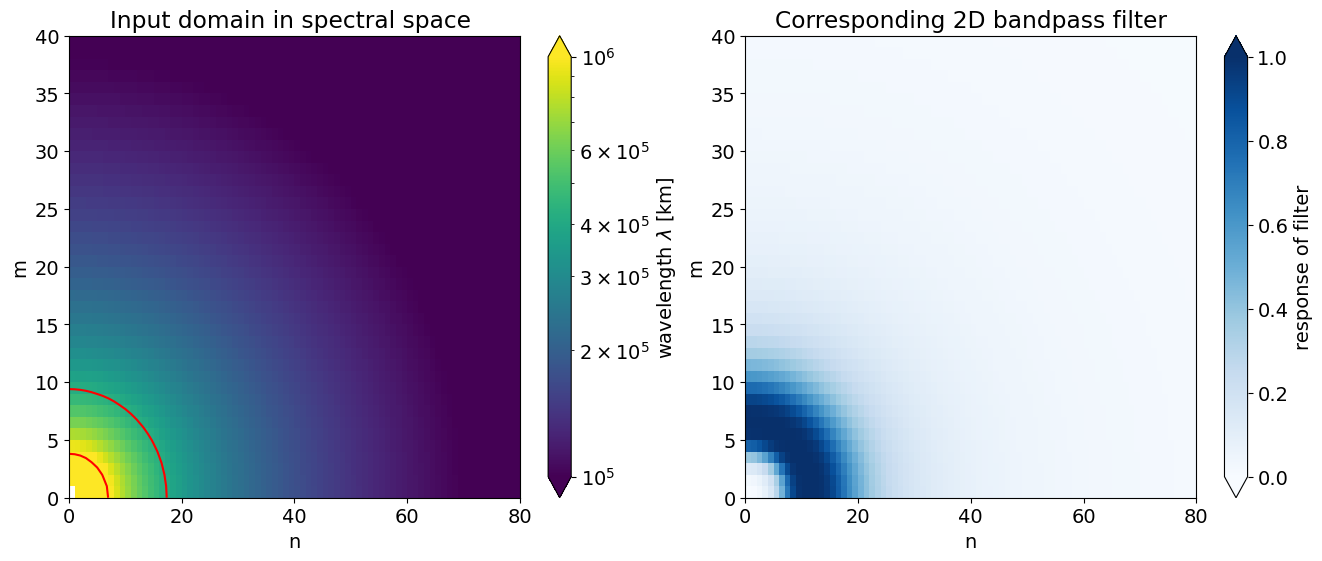

In [12]:
# checkout how the 2D filter looks like
import matplotlib.colors as colors

plt.figure(figsize=(16, 6))

ax = plt.subplot(1, 2, 1)
# 2D field in spectral space
k = ax.pcolormesh(transfer_function[0], norm=colors.LogNorm(1e5, 1e6), shading="auto")
ax.contour(transfer_function[0], lt="-", levels=[lambda_min, lambda_max], colors="r")
plt.colorbar(k, label="wavelength $\lambda$ [km]", extend="both")
ax.set_ylabel("m")
ax.set_xlabel("n")
# zoom in to see relevant wavelengths
ax.set_xlim([0, 80])
ax.set_ylim([0, 40])
ax.set_title("Input domain in spectral space ")

ax = plt.subplot(1, 2, 2)
# 2D filter
tf = ax.pcolormesh(
    transfer_function[1] / np.nanmax(transfer_function[1]), vmin=0, vmax=1, cmap="Blues"
)
plt.colorbar(tf, label="response of filter", extend="both")
ax.set_title("Corresponding 2D bandpass filter")
ax.set_ylabel("m")
ax.set_xlabel("n")
ax.set_xlim([0, 80])
ax.set_ylim([0, 40])

plt.show()

The response of the filter is 1 at locations, where wavelengths are within acceptable range and 0, when the wavelengths are outside of this range (here for: 400  km < $\lambda$ < 1000 km). The transition is smoothed. To better understand this transition, one could also look at the same filter in one dimension (with the red lines indicating the wavelength truncations):

#### The same filter in 1D: 

<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:18: SyntaxWarning: invalid escape sequence '\l'
/var/folders/bj/m6g82c6n41g83y3_dx02y7ch0000gp/T/ipykernel_86601/2571876925.py:18: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title("Transfer function for bandpass filter (400 < $\lambda$ < 1000 km)")


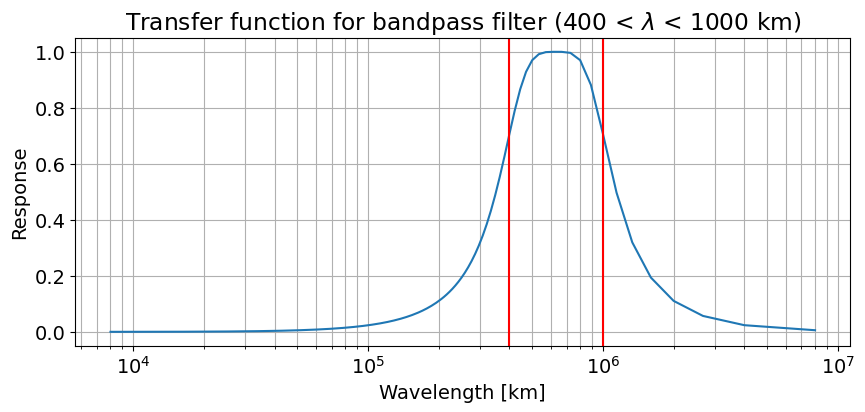

In [13]:
from scipy import signal

# calculate filter according to lambda_min and lambda_max
b, a = signal.iirfilter(
    2,
    [1 / lambda_max, 1 / lambda_min],
    btype="band",
    ftype="butter",
    fs=1 / dxy,
    output="ba",
)
w, h = signal.freqz(b, a, 1000, fs=1 / dxy)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
plt.semilogx(1 / w, abs(h))
# plt.plot(w, h)
ax.set_title("Transfer function for bandpass filter (400 < $\lambda$ < 1000 km)")
ax.set_xlabel("Wavelength [km]")
ax.set_ylabel("Response")
ax.axvline(lambda_min, c="r")
ax.axvline(lambda_max, c="r")
ax.grid(which="both", axis="both")
plt.show()

**If you are happy with how the filter changes your input field, continue as usual with the feature detection and segmentation:**

### Feature detection: 
    
Feature detection is then performed based on the filtered relative vorticity field and your chosen set of thresholds. 

In [14]:
# you can use this function to get the grid spacings from lats and lons
dxy, dt = tobac.utils.general.get_spacings(relative_vorticity, grid_spacing=4e3)
# but better to define exact grid spacing if known, since get_spacings() uses haversine approximation

In [15]:
# if you want your WRF data to indcate the track locations in lons and lats:
relative_vorticity

<xarray.DataArray 'rv500' (time: 168, south_north: 469, west_east: 866)> Size: 546MB
array([[[  3.138932,   3.150467, ...,   5.20407 ,   5.191312],
        [  3.202842,   3.218159, ...,   5.133   ,   5.111225],
        ...,
        [ 11.466752,  11.446242, ...,   2.244073,   2.288456],
        [  6.06062 ,   6.087327, ...,   2.238939,   2.280738]],

       [[  3.063716,   3.038443, ...,   4.815409,   5.123763],
        [  3.141597,   3.124234, ...,   4.726799,   5.030745],
        ...,
        [ 12.680849,  12.979313, ...,   2.141634,   2.294254],
        [ -1.421874,  -1.235242, ...,   2.125223,   2.277909]],

       ...,

       [[ 10.169939,   9.744318, ...,   3.209985,   3.176951],
        [ 10.194508,   9.936515, ...,   3.136149,   3.103187],
        ...,
        [  3.718061,  -0.572581, ..., -28.510893,  -8.78719 ],
        [ 14.069323,  15.725659, ..., -28.109968,  -8.83858 ]],

       [[  9.703144,   8.762362, ...,   2.785694,   2.797884],
        [  9.489581,   8.667569, ...,   2.672183,   2.686641],
        ...,
        [  9.156374,   7.913566, ..., -32.878235, -10.757242],
        [ 20.767054,  15.039678, ..., -33.59285 , -11.135064]]],
      shape=(168, 469, 866))
Coordinates:
  * time         (time) datetime64[ns] 1kB 2008-07-14 ... 2008-07-20T23:00:00
  * south_north  (south_north) int64 4kB 33 34 35 36 37 ... 497 498 499 500 501
  * west_east    (west_east) int64 7kB 741 742 743 744 ... 1603 1604 1605 1606
    latitude     (south_north, west_east) float32 2MB 15.03 15.03 ... 31.98
    longitude    (south_north, west_east) float32 2MB 90.04 90.08 ... 124.4
Attributes:
    long name:      Relative vorticity 500 hPA
    standard name:  relative_vorticity
    units:          10^-5 s-1

In [16]:
# Dictionary containing keyword arguments for feature detection step (Keywords could also be given directly in the function call).
parameters_features = {}
parameters_features["position_threshold"] = "weighted_diff"
parameters_features["sigma_threshold"] = 0.5
parameters_features["min_num"] = 5
parameters_features["n_min_threshold"] = 20
parameters_features["target"] = "maximum"
parameters_features["threshold"] = [3, 5, 8, 10]

In [17]:
# Perform feature detection:
print("starting feature detection")
Features = tobac.feature_detection_multithreshold(
    relative_vorticity,
    dxy=4000,
    **parameters_features,
    wavelength_filtering=(400e3, 1000e3)
)
Features.to_xarray().to_netcdf(savedir / "Features.nc")
print("feature detection performed and saved")

starting feature detection


feature detection performed and saved


### Segmentation  

Segmentation is performed with watershedding based on the detected features and a single threshold value.

In [18]:
# Dictionary containing keyword options for the segmentation step:
parameters_segmentation = {}
parameters_segmentation["target"] = "maximum"
parameters_segmentation["method"] = "watershed"
parameters_segmentation["threshold"] = 1.5

In [19]:
# Perform segmentation and save results:
print("Starting segmentation based on relative vorticity.")
Mask_rv, Features_rv = tobac.segmentation_2D(
    Features, relative_vorticity, dxy, **parameters_segmentation
)
print("segmentation performed, start saving results to files")
Mask_rv.to_netcdf(savedir / "Mask_Segmentation_rv.nc")
Features_rv.to_xarray().to_netcdf(savedir / "Features_rv.nc")
print("segmentation performed and saved")

Starting segmentation based on relative vorticity.


segmentation performed, start saving results to files


segmentation performed and saved


### Trajectory linking

Features are linked into trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.**

In [20]:
# Arguments for trajectory linking:
parameters_linking = {}
parameters_linking["v_max"] = 80
parameters_linking["stubs"] = 2
parameters_linking["order"] = 1
parameters_linking["memory"] = 0
parameters_linking["adaptive_stop"] = 0.2
parameters_linking["adaptive_step"] = 0.95
parameters_linking["subnetwork_size"] = 1000
# require that the vortex has to persist during at least 12 hours
parameters_linking["time_cell_min"] = 12 * dt
parameters_linking["method_linking"] = "predict"

In [21]:
# Perform linking and save results to file:
Track = tobac.linking_trackpy(
    Features, relative_vorticity, dt=dt, dxy=dxy, **parameters_linking
)
Track.to_xarray().to_netcdf(savedir / "Track.nc")

Frame 167: 16 trajectories present.


### Visualisation of tracks

The long track in the east is the mesoscale vortex associated with **typhoon Kalmeagi** that passed Taiwan in July 2008.  

The tracks in the west correspond to vortices that frequently form in the higher mountains over the Tibetan Plateau. 

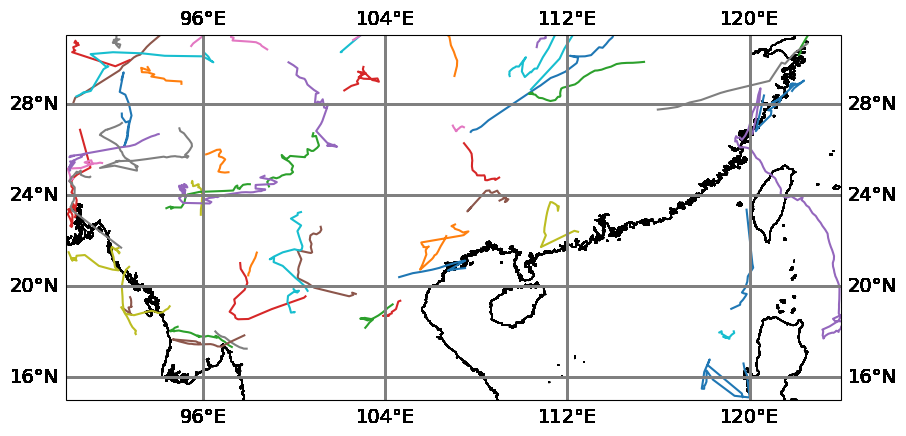

In [22]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs

fig_map, ax_map = plt.subplots(
    figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)
ax_map = tobac.map_tracks(Track, axis_extent=extent, axes=ax_map)